** *
# Microsoft Malware Classification Challenge (BIG 2015)

---


https://www.kaggle.com/c/malware-classification/


>[Microsoft Malware Classification Challenge (BIG 2015)](#scrollTo=zMYQUkNl3e3I)

>[Initial Setup](#scrollTo=U0PO6PE-0JFr)

>>[Download Dataset](#scrollTo=afqc3ABYzOTC)

>[Extract Features](#scrollTo=ms9rLqS_pgRl)



# Initial Setup

## Download Dataset

In [118]:
!pip install kaggle

In [119]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

if not os.path.exists('data/'):

    auth.authenticate_user()

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/content/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)

    !kaggle competitions download -c malware-classification -p data/
    
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [0]:
import re
import glob

import numpy as np
import pandas as pd

import multiprocessing
from multiprocessing.dummy import Pool

In [121]:
cpu_count  = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 3


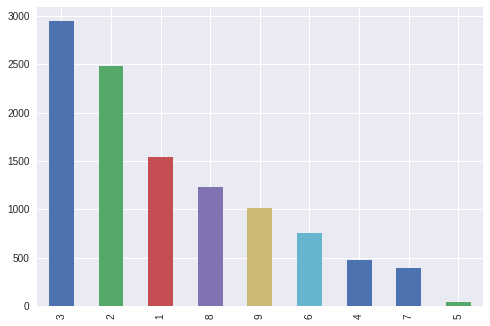

In [122]:
trainLabels = pd.read_csv('data/trainLabels.csv')
trainLabels.Class.value_counts().plot(kind = 'bar')

In [123]:
!apt-get install p7zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-4).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
#!cd data && p7zip -d train.7z

# Extract Features

In [0]:
def getOpcodes(file2path):

    openfile = io.open(file2path,'r',encoding='latin-1')
    lines=openfile.readlines()

    opcodes_lst = []

    for line in lines:
        opcode_group = re.search('\s\s\s[a-z][a-z]+\s\s\s',line)
        if opcode_group:
            opcode = opcode_group.group().strip()
            opcodes_lst.append(opcode)
            
    return opcodes_lst, file2path

In [0]:
def extractInParallel(path_lst, threads=2):
    
    pool = Pool(threads)
    result = pool.map(getOpcodes, path_lst)
    pool.close()
    pool.join()
    return result

In [0]:
def extractFeatures(path2data, format_file = '*.asm'):
  
    for subdir, dirs, files in os.walk(path2data):
          print('Reading files from dir: {}'.format(subdir))
          path_folder = os.path.join(subdir, format_file)
          filesPath = glob.glob(path_folder) 

          res =  extractInParallel(filesPath, threads=cpu_count)
    return res

In [128]:
path2train = 'data/train'
train_data = extractFeatures(path2train)

Reading files from dir: data/train


In [0]:
def format_data(data):

  X, y = [], []
  for opcodes, filename in data:
      X.append(opcodes)
      y.append(filename)
      
  return X, y

In [0]:
X_train, y_train = format_data(train_data)

## Saving features

In [0]:
def save_features(X, y, file, path2save):

    os.makedirs(path2save)
    
    data ={'X':X, 'y':y}
    np.savez(path2save + file + ".npz",**data)

    print('Saved in: {}'.format(path2save))  

In [147]:
path2saveTrain = 'features/train/'

if not os.path.exists(path2save):
    save_features(X_train, y_train,'opcodes', path2saveTrain)

else:
    print('Features already obtained!')

Saved in: features/train/
